In [1]:
%matplotlib inline

import pandas
import random
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.stats

import tensorflow as tf
from tensorflow.contrib import layers
from tensorflow.contrib import learn

/Users/ipolosukhin/projects/tf_examples/.env/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
# Sets logging to INFO to see all information from TensorFlow.

tf.logging.set_verbosity(tf.logging.INFO)

In [49]:
BASE_DIR = 'adversarial_sentiment/'

In [24]:
# Load data

train = pandas.read_csv('data/sentiment-train.tsv', sep='\t')
y = train['Sentiment']
X = train['Phrase']
train_x, test_x, train_y, test_y = learn.estimators._sklearn.train_test_split(X, y, test_size=0.2, random_state=42)

train

,PhraseId,SentenceId,Phrase,Sentiment
0,1,1,A series of escapades demonstrating the adage ...,1
1,2,1,A series of escapades demonstrating the adage ...,2
2,3,1,A series,2
3,4,1,A,2
4,5,1,series,2
5,6,1,of escapades demonstrating the adage that what...,2
6,7,1,of,2
7,8,1,escapades demonstrating the adage that what is...,2
8,9,1,escapades,2
9,10,1,demonstrating the adage that what is good for ...,2


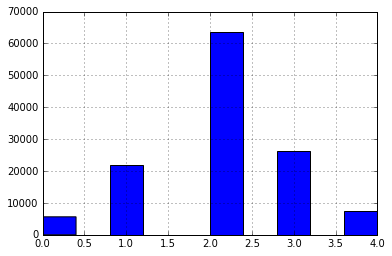

In [25]:
train_y.hist()

In [26]:
# Preprocess dataset.
MAX_DOCUMENT_LENGTH = 15

vocab_processor = learn.preprocessing.VocabularyProcessor(max_document_length=MAX_DOCUMENT_LENGTH)
train_x = np.array(list(vocab_processor.fit_transform(train_x)))
test_x = np.array(list(vocab_processor.transform(test_x)))

n_words = len(vocab_processor.vocabulary_)
print('Total words: %d' % n_words)

Total words: 18089


In [53]:
EMBEDDING_SIZE = 50

def bow_model(features, target):
    target = tf.one_hot(target, 5, 1.0, 0.0)
    word_vectors = learn.ops.categorical_variable(
        features, n_classes=n_words,
        embedding_size=EMBEDDING_SIZE, name='words')
    features = tf.reduce_max(word_vectors, reduction_indices=1)
    logits = layers.fully_connected(features, 5, activation_fn=None)
    loss = tf.contrib.losses.softmax_cross_entropy(logits, target)
    train_op = layers.optimize_loss(
        loss, tf.contrib.framework.get_global_step(), learning_rate=0.05, 
        optimizer='Adagrad')
    return tf.argmax(logits, dimension=1), loss, train_op

bow_classifier = learn.Estimator(model_fn=bow_model, model_dir=BASE_DIR + 'bow')
bow_classifier.fit(x=train_x, y=train_y, steps=5000, batch_size=128)

INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Step 1: loss = 1.60955
INFO:tensorflow:Step 101: loss = 1.26434
INFO:tensorflow:Step 201: loss = 1.2356
INFO:tensorflow:Saving checkpoints for 300 into adversarial_sentiment/bow/model.ckpt.
INFO:tensorflow:Step 301: loss = 1.25715
INFO:tensorflow:Step 401: loss = 1.22059
INFO:tensorflow:Step 501: loss = 1.34845
INFO:tensorflow:Saving checkpoints for 600 into adversarial_sentiment/bow/model.ckpt.
INFO:tensorflow:Step 601: loss = 1.06565
INFO:tensorflow:Step 701: loss = 1.21531
INFO:tensorflow:Step 801: loss = 1.15981
INFO:tensorflow:Saving checkpoints for 900 into adversarial_sentiment/bow/model.ckpt.
INFO:tensorflow:Step 901: loss = 1.27377
INFO:tensorflow:Step 1001: loss = 1.23933
INFO:tensorflow:Step 1101: loss = 1.17093
INFO:tensorflow:Saving checkpoints for 1200 into adversarial_sentiment/bow/model.ckpt.
INFO:tensorflow:Step 1201: loss = 1.15219
INFO:tensorflow:Step 1301: loss = 1.26084
INFO:tensorflow:Step 1401: loss = 1.16772

Estimator(params=None)

In [54]:
pandas.DataFrame([bow_classifier.evaluate(
    x=test_x, y=test_y,
    metrics={'accuracy': tf.contrib.metrics.streaming_accuracy})])

INFO:tensorflow:Restored model from adversarial_sentiment/bow/model.ckpt-5000-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 5000.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 5000 step: loss = 1.04754, accuracy = 0.587178


,accuracy,global_step,loss
0,0.587178,5000,1.047538


In [55]:
def rnn_model(features, target):
    target = tf.one_hot(target, 5, 1.0, 0.0)
    word_vectors = learn.ops.categorical_variable(
        features, n_classes=n_words,
        embedding_size=EMBEDDING_SIZE, name='words')
    word_list = tf.unpack(word_vectors, axis=1)
    cell = tf.nn.rnn_cell.GRUCell(EMBEDDING_SIZE)
    _, encoding = tf.nn.rnn(cell, word_list, dtype=tf.float32)
    logits = layers.fully_connected(encoding, 5, activation_fn=None)
    loss = tf.contrib.losses.softmax_cross_entropy(logits, target)
    train_op = layers.optimize_loss(
        loss, tf.contrib.framework.get_global_step(), learning_rate=0.05, 
        optimizer='Adagrad')
    return tf.argmax(logits, dimension=1), loss, train_op

rnn_classifier = learn.Estimator(model_fn=rnn_model, model_dir=BASE_DIR + 'rnn')
rnn_classifier.fit(x=train_x, y=train_y, steps=5000, batch_size=128)

Instructions for updating:
Please use tf.unpack instead.
INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Step 1: loss = 1.61243
INFO:tensorflow:Step 101: loss = 1.26846
INFO:tensorflow:Step 201: loss = 1.23199
INFO:tensorflow:Saving checkpoints for 300 into adversarial_sentiment/rnn/model.ckpt.
INFO:tensorflow:Step 301: loss = 1.23385
INFO:tensorflow:Step 401: loss = 1.19263
INFO:tensorflow:Step 501: loss = 1.32969
INFO:tensorflow:Saving checkpoints for 600 into adversarial_sentiment/rnn/model.ckpt.
INFO:tensorflow:Step 601: loss = 1.04041
INFO:tensorflow:Step 701: loss = 1.20891
INFO:tensorflow:Step 801: loss = 1.14886
INFO:tensorflow:Saving checkpoints for 900 into adversarial_sentiment/rnn/model.ckpt.
INFO:tensorflow:Step 901: loss = 1.33269
INFO:tensorflow:Step 1001: loss = 1.22563
INFO:tensorflow:Step 1101: loss = 1.15786
INFO:tensorflow:Saving checkpoints for 1200 into adversarial_sentiment/rnn/model.ckpt.
INFO:tensorflow:Step 1201: loss = 1.148
INFO:tensorflow:Step 1301: 

Estimator(params=None)

In [56]:
pandas.DataFrame([rnn_classifier.evaluate(
    x=test_x, y=test_y,
    metrics={'accuracy': tf.contrib.metrics.streaming_accuracy})])

Instructions for updating:
Please use tf.unpack instead.
INFO:tensorflow:Restored model from adversarial_sentiment/rnn/model.ckpt-5000-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 5000.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 5000 step: loss = 0.972781, accuracy = 0.611399


,accuracy,global_step,loss
0,0.611399,5000,0.972781


In [62]:
# Utility function to create adversarial examples.

def get_adversarial_example(features, loss, norm):
    gradient = tf.gradients(loss, features, aggregation_method=2)
    gradient = tf.stop_gradient([g for g in gradient if g is not None])
    r_adv = norm * tf.nn.l2_normalize(gradient, dim=1)
    r_adv = tf.reduce_sum(r_adv, reduction_indices=[0])
    return features + r_adv

In [67]:
ADV_LOSS_WEIGHT = 0.5

def adv_rnn_model(features, target):
    features = tf.identity(features, name='features')
    target = tf.one_hot(target, 5, 1.0, 0.0)
    # Convert features to word vectors.
    features = learn.ops.categorical_variable(
        features, n_classes=n_words,
        embedding_size=EMBEDDING_SIZE, name='words')
    def model(features):
        word_list = tf.unpack(features, axis=1)
        cell = tf.nn.rnn_cell.GRUCell(EMBEDDING_SIZE)
        _, encoding = tf.nn.rnn(cell, word_list, dtype=tf.float32)
        logits = layers.fully_connected(encoding, 5, activation_fn=None)
        loss = tf.contrib.losses.softmax_cross_entropy(logits, target)
        return logits, loss
    with tf.variable_scope('model'):
        logits, orig_loss = model(features)
    adv_features = tf.identity(get_adversarial_example(features=features, loss=orig_loss, norm=0.1), name='adv_features')
    tf.identity(adv_features - features, name='adv_diff')
    with tf.variable_scope('model', reuse=True):
        adv_logit, adv_loss = model(adv_features)
    adv_pred = tf.argmax(adv_logit, dimension=1, name='adv_prediction')
    loss = orig_loss + ADV_LOSS_WEIGHT * adv_loss
    train_op = layers.optimize_loss(
        loss, tf.contrib.framework.get_global_step(), learning_rate=0.05, 
        optimizer='Adagrad')
    return tf.argmax(logits, dimension=1), loss, train_op

adversarial_rnn_classifier = learn.Estimator(model_fn=adv_rnn_model, model_dir=BASE_DIR + 'adv_rnn')
adversarial_rnn_classifier.fit(x=train_x, y=train_y, steps=5000, batch_size=128)

INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Restored model from adversarial_sentiment/adv_rnn/model.ckpt-5000-?????-of-00001
INFO:tensorflow:Step 5001: loss = 1.742
INFO:tensorflow:Saving checkpoints for 5001 into adversarial_sentiment/adv_rnn/model.ckpt.
INFO:tensorflow:Step 5101: loss = 1.82385
INFO:tensorflow:Step 5201: loss = 1.70035
INFO:tensorflow:Step 5301: loss = 1.71686
INFO:tensorflow:Saving checkpoints for 5301 into adversarial_sentiment/adv_rnn/model.ckpt.
INFO:tensorflow:Step 5401: loss = 1.67291
INFO:tensorflow:Step 5501: loss = 1.87845
INFO:tensorflow:Step 5601: loss = 1.40581
INFO:tensorflow:Saving checkpoints for 5601 into adversarial_sentiment/adv_rnn/model.ckpt.
INFO:tensorflow:Step 5701: loss = 1.70321
INFO:tensorflow:Step 5801: loss = 1.62831
INFO:tensorflow:Step 5901: loss = 1.89951
INFO:tensorflow:Saving checkpoints for 5901 into adversarial_sentiment/adv_rnn/model.ckpt.
INFO:tensorflow:Step 6001: loss = 1.7182
INFO:tensorflow:Step 6101: loss = 1.72493

Estimator(params=None)

In [70]:
adversarial_rnn_classifier.fit(
    x=train_x, y=train_y, steps=1, batch_size=1,
    monitors=[learn.monitors.PrintTensor(['adv_prediction', 'features', 'adv_features'], every_n=1)])

INFO:tensorflow:Create CheckpointSaver
INFO:tensorflow:Restored model from adversarial_sentiment/adv_rnn/model.ckpt-10000-?????-of-00001
INFO:tensorflow:Step 10001: adv_features = [[[-0.09856126 -0.09312834 -0.08946314  0.0410028   0.10420589  0.10681324
    0.09001259  0.08756039  0.0987272  -0.09019977 -0.11129735 -0.10305759
   -0.0890535  -0.09727825 -0.09626564  0.10022548  0.09829236  0.10965458
   -0.07882576  0.09821449 -0.10032161 -0.09028951  0.10962603 -0.09472139
   -0.10885916  0.09345677 -0.10487392 -0.10754646 -0.10600623  0.08885272
    0.08677614 -0.1087176  -0.09662693  0.10833728  0.11023705  0.10761855
   -0.15223123 -0.11148477  0.09590916 -0.10605043  0.09522453 -0.1092566
   -0.0983576   0.10119615 -0.10699889  0.10892528 -0.0907819   0.10463062
   -0.10854153  0.10294732]
  [-0.11224194 -0.08907159 -0.10569058  0.0692647  -0.09804207 -0.08771527
    0.10155439  0.10553519  0.09027489 -0.09295928  0.10048214 -0.0898969
   -0.10612247  0.09854729 -0.11076172  0.11

Estimator(params=None)

In [68]:
pandas.DataFrame([adversarial_rnn_classifier.evaluate(
    x=test_x, y=test_y,
    metrics={'accuracy': tf.contrib.metrics.streaming_accuracy})])

INFO:tensorflow:Restored model from adversarial_sentiment/adv_rnn/model.ckpt-10000-?????-of-00001
INFO:tensorflow:Eval steps [0,inf) for training step 10000.
INFO:tensorflow:Input iterator is exhausted.
INFO:tensorflow:Saving evaluation summary for 10000 step: loss = 1.54573, accuracy = 0.592048


,accuracy,global_step,loss
0,0.592048,10000,1.545733
